# Logistic Regression
Logistic regression is different from linear regression in that it is used for classification. In this notebook, we will use it for binary classification on generated data as well as a Kaggle data set for car purchases. Like linear regression, gradient descent for logistic regression uses the information at the current epoch to improve the model until it converges (hopefully).

## Libraries
The standard math library will be used for the exponential function. pandas DataFrames are good for data pre-processing but have slow indexing, so calculations for the algorithm will be done with NumPy arrays. scikit-learn has a function that splits the data into training and validation data sets. Finally, the progression of the model can be visualized using Matplotlib.

In [1]:
import math
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

## Algorithm
Since exponentials will be used, we need to normalize our data to make sure the loss does not cause overflow or other issues. Min-max normalization is simple but efficient, linearly scaling the data between 0 and 1.

$$v_{new}=\frac{v_{old}-min(v_{old})}{max(v_{old})-min(v_{old})}$$

In [2]:
def normalize_minmax(data):
    data = (data - data.min(axis=0)) / (data.max(axis=0) - data.min(axis=0))
    return data

Logistic regression uses the sigmoid function to make its prediction as a linear function will not return a value between 0 and 1.

$$\sigma(x)=\frac{1}{1+e^{-x}}$$

Since $x$ is a single value, we can represent it as a linear combination, $z$, of the data.

$$z=\beta_0+\beta_1x_1+\beta_2x_2+\ldots+\beta_mx_m$$

$$\sigma(z)=\frac{1}{1+e^{-z}}$$

The `z` function calculates this linear combination, and the `prob` function calculates $\sigma$, the model's prediction expressed as a probability.

In [3]:
def z(point, betas):
    return betas[0] + np.dot(betas[1:], point.T)

def prob(betas, point):
    u = z(point, betas)
    return 1 / (1 + math.exp(-u))

If we try to use mean squared error for logistic regression, the model will have difficulty converging to the minimum because there will be more than one local minimum. Therefore, we must use a different cost function, i.e. log loss.

$$J=-\frac{1}{n}\sum_{i=1}^{n} (y_i \log(\sigma_i)+(1-y_i)\log(1-\sigma_i))$$

The natural logarithm of the probability returned by the model is taken at each data point. Because both 0 and 1 are possible labels, the probability for label 0 is subtracted from 1 to calculate the confidence for a prediction of 0.

In [ ]:
def log_loss(betas, data):
    rows, cols = data.shape
    loss = 0
    for i in range(rows):
        cli = data[i][cols - 1]
        pi = prob(betas, data[i][:cols - 1])
        loss += cli * math.log(pi) + (1 - cli) * math.log(1 - pi)
    loss *= -1 / rows
    return loss

We also want to keep track of the accuracy of the logistic regression, so the `accuracy` function predicts a class for each of the data points, and the proportion of correct predictions to total predictions is returned.

In [ ]:
def accuracy(betas, data, threshold):
    rows, cols = data.shape
    acc = 0
    for i in range(rows):
        cli = data[i][cols - 1]
        pi = prob(betas, data[i][:cols - 1])
        acc += cli * pi + (1 - cli) * (1 - pi) >= threshold
    acc /= rows
    return acc

### Gradient Descent
The gradient descent for logistic regression uses the same fundamental formula as linear regression to update the $\beta$-values, but since the cost function is different, computation will slightly vary.

$$\beta_{k_{new}}=\beta_{k_{old}}-\alpha\frac{\partial J}{\partial \beta_k}$$

$$\frac{\partial J}{\partial \beta_k}=-\frac{1}{n}\sum_{i=1}^{n} \sigma_i(y_ie^{-z}+y_i-1) \text{    for } k=0$$
$$\frac{\partial J}{\partial \beta_k}=-\frac{1}{n}\sum_{i=1}^{n} \sigma_i(y_ie^{-z}+y_i-1)x_{k_i} \text{    for } k>0$$

In [4]:
def iterate(betas, data_train, data_test, epochs, learning_rate):
    metrics = {
        'loss_train': [log_loss(betas, data_train)],
        'loss_test': [log_loss(betas, data_test)],
        'acc_train': [accuracy(betas, data_train, 0.5)],
        'acc_test': [accuracy(betas, data_test, 0.5)]
    }
    rows, cols = data_train.shape
    for k in range(epochs):
        dbetas = np.zeros(len(betas))
        for i in range(rows):
            u = z(data_train[i][:cols - 1], betas)
            temp = prob(betas, data_train[i][: cols - 1]) * (data_train[i][cols - 1] * math.exp(-u) + data_train[i][cols - 1] - 1)
            dbetas[0] += temp
            dbetas[1:] += data_train[i][:cols - 1] * temp
        dbetas *= -1 / rows
        betas -= dbetas * learning_rate
        metrics['loss_train'].append(log_loss(betas, data_train))
        metrics['loss_test'].append(log_loss(betas, data_test))
        metrics['acc_train'].append(accuracy(betas, data_train, 0.5))
        metrics['acc_test'].append(accuracy(betas, data_test, 0.5))
    return metrics

## Training and Testing
The generated data used for this first example is a list of 1000 random values placed between 0 and 100. The class is labeled 1 for values greater than 50 and labeled 0 otherwise.

We first normalize then split the data into 90% training and 10% validation sets.

In [5]:
data = pd.read_csv('logreg_data.csv').to_numpy()
data = normalize_minmax(data)
train, test = train_test_split(data, test_size=0.1, shuffle=True)

In [6]:
betas = np.zeros(data.shape[1])

eps = 100
lr = 1
metrics = iterate(betas, train, test, eps, lr)

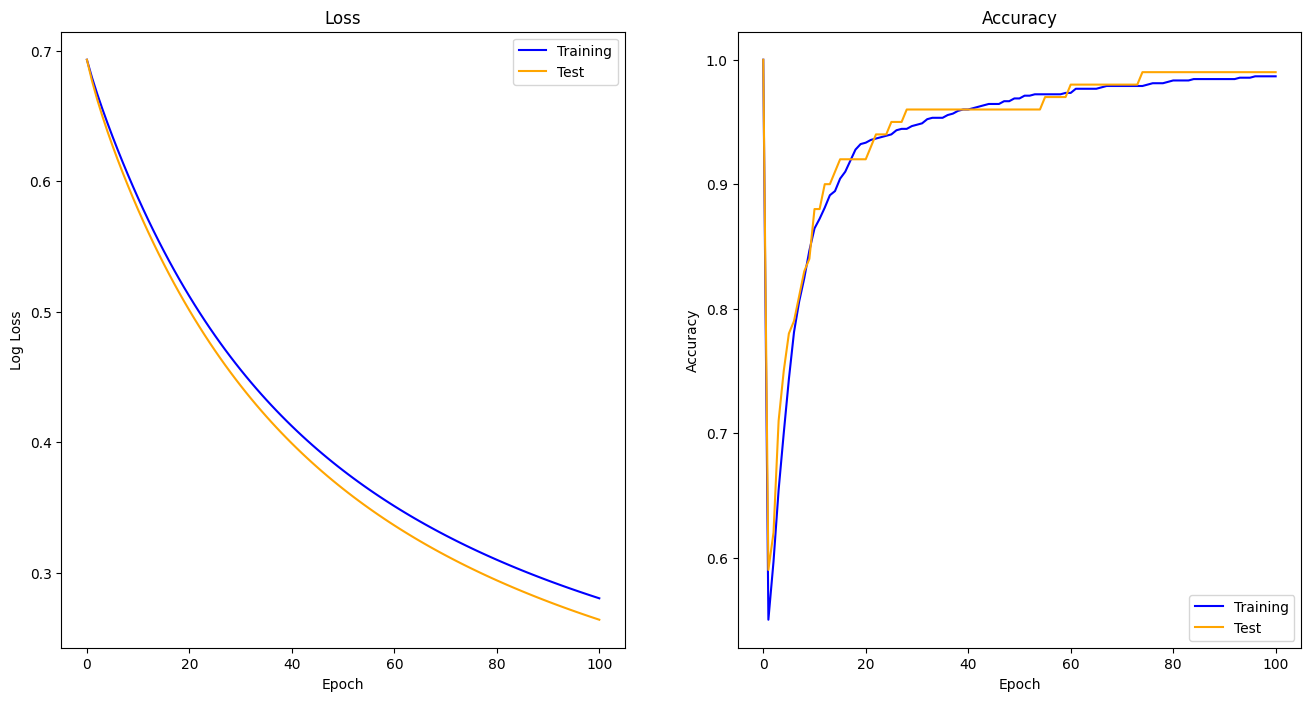

In [7]:
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.plot(range(eps + 1), metrics['loss_train'], c='blue', label='Training')
plt.plot(range(eps + 1), metrics['loss_test'], c='orange', label='Test')
plt.legend(loc='upper right')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Log Loss')

plt.subplot(1, 2, 2)
plt.plot(range(eps + 1), metrics['acc_train'], c='blue', label='Training')
plt.plot(range(eps + 1), metrics['acc_test'], c='orange', label='Test')
plt.legend(loc='lower right')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.show()

In [8]:
cars = pd.read_csv('car_data.csv')
cars = cars[['Gender', 'Age', 'AnnualSalary', 'Purchased']]
cars = cars.transform(lambda x: (x == 'Male') * 1 if x.name == 'Gender' else x)
cars = normalize_minmax(cars.to_numpy())
train, test = train_test_split(cars, test_size=0.1, shuffle=True)

In [9]:
betas = np.zeros(cars.shape[1])

eps = 250
lr = 5
metrics = iterate(betas, train, test, eps, lr)

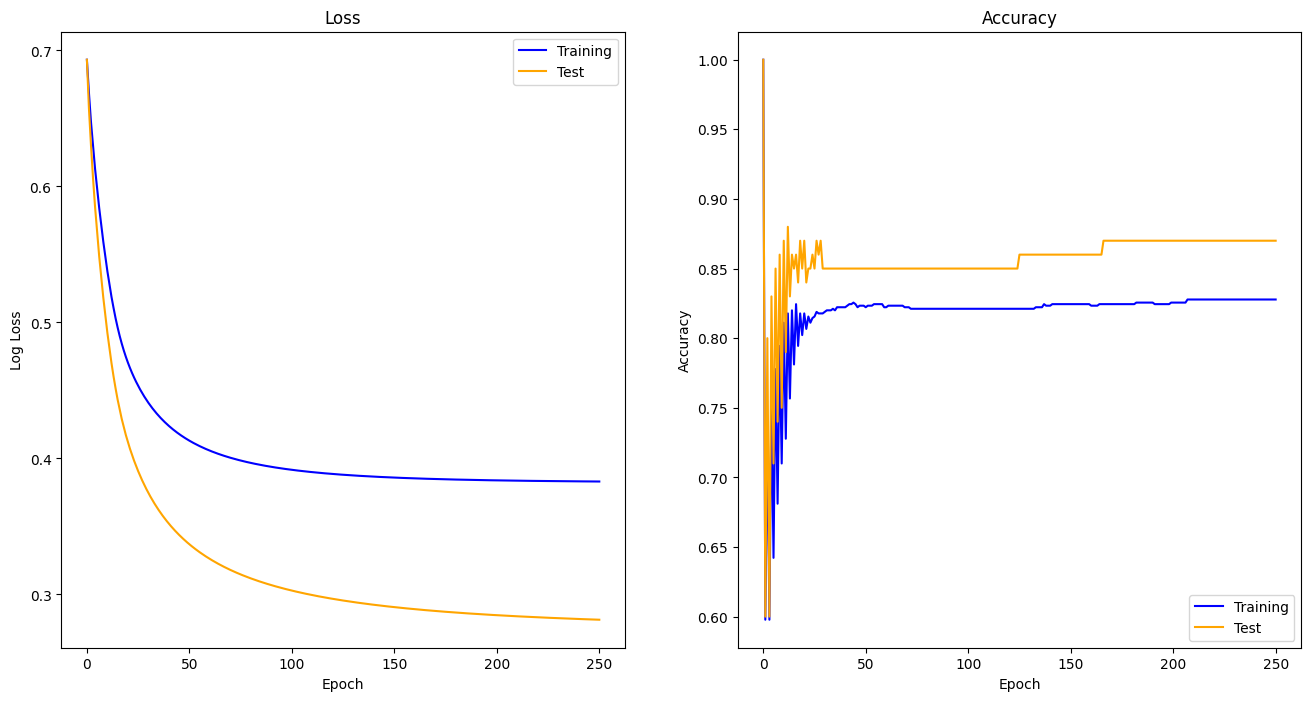

In [10]:
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.plot(range(eps + 1), metrics['loss_train'], c='blue', label='Training')
plt.plot(range(eps + 1), metrics['loss_test'], c='orange', label='Test')
plt.legend(loc='upper right')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Log Loss')

plt.subplot(1, 2, 2)
plt.plot(range(eps + 1), metrics['acc_train'], c='blue', label='Training')
plt.plot(range(eps + 1), metrics['acc_test'], c='orange', label='Test')
plt.legend(loc='lower right')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.show()

In [11]:
pred = 15
print(test[pred][cars.shape[1] - 1])
print(prob(betas, test[pred][:cars.shape[1] - 1]))

0.0
0.004860561860357176
